<a href="https://colab.research.google.com/github/ayushnangia/Test/blob/main/finetuning_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers pytorch-lightning

In [ ]:
import os
from google.colab import drive

In [ ]:
import matplotlib.pyplot as plt
drive.mount("/content/drive",force_remount=False)

Mounted at /content/drive


In [ ]:
train_path="/content/drive/MyDrive/Colab Notebooks/UCC/train.csv"

In [ ]:
val_path="/content/drive/MyDrive/Colab Notebooks/UCC/val.csv"

In [ ]:
import pandas as pd
train_data=pd.read_csv(train_path)

In [ ]:
train_data.head(0)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence


In [ ]:
attri=['antagonize','condescending','dismissive','generalisation',
       'generalisation_unfair','healthy','hostile','sarcastic',]

<Axes: >

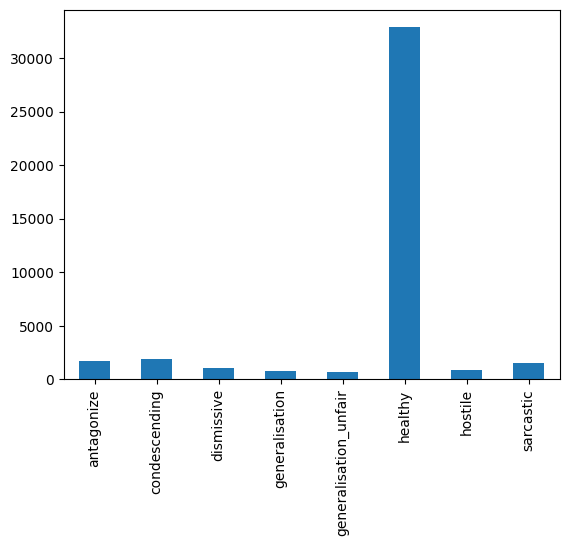

In [ ]:
train_data[attri].sum().plot.bar()


<Axes: >

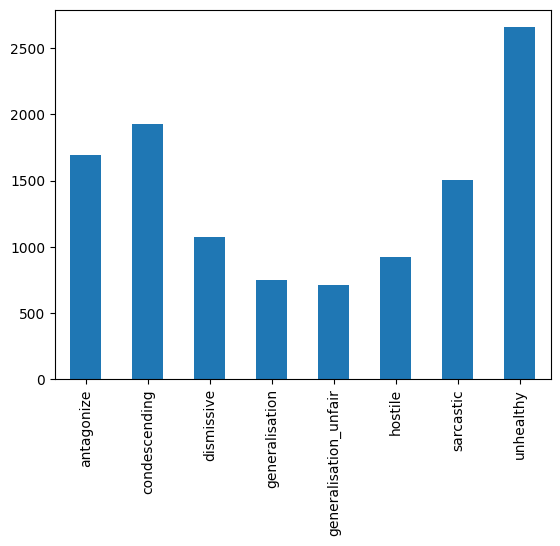

In [ ]:
import numpy as np
train_data['unhealthy']=np.where(train_data['healthy']==1,0,1)
attri=['antagonize','condescending','dismissive','generalisation',
       'generalisation_unfair','hostile','sarcastic','unhealthy']
train_data[attri].sum().plot.bar()


In [ ]:
from torch.utils.data import Dataset
import torch

In [ ]:
class UCC_dataset(Dataset):
  def __init__(self,data_path,tokenizers, attributes,max_token_len : int =128, sample=5000):
    self.data_path=data_path
    self.tokenizers=tokenizers
    self.attributes=attributes
    self.max_token_len=max_token_len
    self.sample=sample
    self._prep_data()

  def _prep_data(self):
    data=pd.read_csv(self.data_path)
    data['unhealthy']=np.where(data['healthy']==1,0,1)
    if self.sample is not None:
      unhealthy= data.loc[data[self.attributes].sum(axis=1)>0]
      healthy= data.loc[data[self.attributes].sum(axis=1)==0]
      self.data=pd.concat([unhealthy,healthy.sample(self.sample,random_state=7)])
    else:
      self.data=data
  def __len__(self):
    return len(self.data)
  def __getitem__(self,index):
    item=self.data.iloc[index]
    comment=str(item.comment)
    attributed=torch.FloatTensor(item[self.attributes])
    tokens=self.tokenizers.encode_plus(comment,
                                       add_special_tokens=True,
                                       return_tensors="pt",
                                       truncation=True,
                                       max_length=self.max_token_len,
                                       padding='max_length',
                                       return_attention_mask=True
                                       )
    return {'input_ids': tokens.input_ids.flatten(),'attention_mask':tokens.attention_mask.flatten(),"labels": attributed}

In [ ]:
from transformers import AutoTokenizer
model_n='roberta-base'
tokenizer=AutoTokenizer.from_pretrained(model_n)
ucc_ds=UCC_dataset(train_path,tokenizer,attributes=attri)
ucc_ds_val=UCC_dataset(val_path,tokenizer,attributes=attri,sample=None)

In [ ]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

### Data module

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader


In [ ]:
class UCC_Data_Module(pl.LightningDataModule):
  def __init__(self,train_path,val_path,attributes,batch_size: int =16,
              max_token_len: int=128, model_name='roberta-base'):
    super().__init__()
    self.train_path=train_path
    self.val_path=val_path
    self.attributes=attributes
    self.max_token_len=max_token_len
    self.batch_size=batch_size
    self.model_name=model_name
    self.tokenizer=AutoTokenizer.from_pretrained(model_name)
  def setup(self,stage=None):
     if stage in (None,'fit'):
      self.train_dataset= UCC_dataset(self.train_path,self.tokenizer,self.attributes)
      self.val_dataset= UCC_dataset(self.val_path,self.tokenizer,self.attributes,sample=None)
     if stage=="predict":
      self.val_dataset= UCC_dataset(self.val_path,self.tokenizer,self.attributes,sample=None)
  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size=self.batch_size,num_workers=4,shuffle=True)
  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size=self.batch_size,num_workers=4,shuffle=False)
  def predict_dataloader(self):
    return DataLoader(self.val_dataset,batch_size=self.batch_size,num_workers=4,shuffle=False)


In [ ]:
ucc_data_module=UCC_Data_Module(train_path,val_path,attributes=attri)

In [ ]:
ucc_data_module.setup()

In [ ]:
dl=ucc_data_module.train_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(dl)

623

### Model

![Imgur](https://i.imgur.com/9VzdYA5.png)

In [ ]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as f


In [ ]:
class UCC_classifier(pl.LightningModule):
  def __init__(self, config : dict):
    super().__init__()
    self.config=config
    self.pretrained_model=AutoModel.from_pretrained(config['model_name'],return_dict=True)
    self.hidden=nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
    self.classifier=nn.Linear(self.pretrained_model.config.hidden_size,self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.hidden.weight)
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func=nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout=nn.Dropout()


  def forward(self,input_ids,attention_mask,labels=None):
    output=self.pretrained_model(input_ids=input_ids,attention_mask=attention_mask)
    pooled_output=torch.mean(output.last_hidden_state,1)

    pooled_output=self.hidden(pooled_output)
    pooled_output=self.dropout(pooled_output)
    pooled_output=f.relu(pooled_output)
    logits=self.classifier(pooled_output)

    loss=0
    if labels is not None:
      loss=self.loss_func(logits.view(-1,self.config['n_labels']),labels.view(-1,self.config['n_labels']))
    return loss,logits
  def training_step(self,batch,batch_index):
    loss,logits=self(**batch)
    self.log('train loss',loss,prog_bar=True,logger=True)
    return {'loss':loss,'predictions':logits,'labels':batch['labels']}

  def validation_step(self,batch,batch_index):
    loss,logits=self(**batch)
    self.log('val loss',loss,prog_bar=True,logger=True)
    return {'val_loss':loss,'predictions':logits,'labels':batch['labels']}

  def predict_step(self,batch,batch_index):
    _,logits=self(**batch)
    return logits
  def configure_optimizers(self):
    optimizer=torch.optim.AdamW(self.parameters(),lr=self.config['lr'],weight_decay=self.config['w_decay'])
    total_steps=self.config['train_size']/self.config['bs']
    warmup_steps=math.floor(total_steps*self.config['warmup'])
    scheduler=get_cosine_schedule_with_warmup(optimizer,warmup_steps,total_steps)
    return [optimizer],[scheduler]

In [ ]:
## can use the og model roberta too may need pro?
config={
    'model_name':'roberta-base',
    'n_labels':len(attri),
    'bs':128,
    'lr': 1.5e-6,
    'warmup':0.2,
    'train_size':len(ucc_data_module.train_dataloader()),
    'w_decay':0.001,
    'n_epochs':100
}
model=UCC_classifier(config)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
idx=0
input_ids=ucc_ds.__getitem__(idx)['input_ids']
am=ucc_ds.__getitem__(idx)['attention_mask']
labels=ucc_ds.__getitem__(idx)['labels']
loss,output=model(input_ids.unsqueeze(dim=0),am.unsqueeze(dim=0),labels.unsqueeze(dim=0))

In [ ]:
loss,output

(tensor(0.6729, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[-0.0611,  0.8362,  0.0755, -0.3868, -0.1712, -0.8882,  0.0699,  0.2197]],
        grad_fn=<AddmmBackward0>))

###*Train*

In [ ]:
ucc_data_module=UCC_Data_Module(train_path,val_path,attri,batch_size=config['bs'])
ucc_data_module.setup()

model=UCC_classifier(config)

torch.save(model.state_dict(), 'my_model.pth')

trainer=pl.Trainer(max_epochs=config['n_epochs'],num_sanity_val_steps=50)
trainer.fit(model,ucc_data_module)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | RobertaModel      | 124 M 
1 | hidden           | Linear            | 590 K 
2 | classifier       | Linear            | 6.2 K

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model_pathh="/content/drive/MyDrive/Colab Notebooks/weight_model_robert-base.ckpt"
trainer.save_checkpoint(model_pathh)

In [ ]:
from huggingface_hub import login
login()

In [ ]:
model.push_to_hub("UCC-finetuned-roberta-base")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

### Predict with model

In [ ]:
def classify_raw_comments(model,dm):
  predictions=trainer.predict(model,datamodule=dm)
  predictions
  flattened_predictions=np.stack([torch.sigmoid(torch.Tensor(p))for batch in predictions for p in batch])
  return flattened_predictions

SyntaxError: ignored

In [ ]:
predictions=classify_raw_comments(model, ucc_data_module)


NameError: ignored

In [ ]:
val_data=pd.read_csv(val_path)
val_data['unhealthy']=np.where(val_data["healthy"]=1,0,1)
true_labels=np.arrays(val_data[attri])


NameError: ignored

In [ ]:
from sklearn import metrics
